In [1]:
# from fastai import learner
from fastai.vision.all import *
import numpy as np
import os
import pandas as pd
import librosa as lb
import librosa.display
import soundfile as sf
import matplotlib.patches as patch
import matplotlib.pyplot as plt
import IPython.display as ipd
from pathlib import Path
from tqdm.notebook import tqdm
from scipy.io import wavfile
from torch import cuda


CC_ROOT=Path("D:\\KidElectric\\rfcx_kaggle") #Cookiecutter datascience-style project
CC_DATA_OUT=CC_ROOT.joinpath('data').joinpath('interim')

DATA_ROOT = CC_ROOT.joinpath('data')
TRAIN_AUDIO_ROOT = DATA_ROOT.joinpath('raw').joinpath('train')#Update to point to cookiecutter data/raw/train
TEST_AUDIO_ROOT = DATA_ROOT.joinpath('raw').joinpath('test')#Update to point to cookiecutter data/raw/test


df_train = pd.DataFrame({
    "recording_id": [path.stem for path in TRAIN_AUDIO_ROOT.glob("*.flac")],
})

df_test = pd.DataFrame({
    "recording_id": [path.stem for path in TEST_AUDIO_ROOT.glob("*.flac")],
})

df_tp=pd.read_csv(CC_ROOT.joinpath('references').joinpath('train_tp.csv')).set_index('recording_id')

df_fp=pd.read_csv(CC_ROOT.joinpath('references').joinpath('train_fp.csv')).set_index('recording_id')


In [5]:
cuda.empty_cache()

In [3]:
path

Path('D:/KidElectric/rfcx_kaggle/data/interim/clip_decomp')

In [6]:
# 1 model trained on TP and FP test
def which_singer(x): return x.parts[-1].split('_')[1]

path =CC_DATA_OUT.joinpath('train').joinpath('clip_decomp')
#mixup = MixUp(0.5) #or whatever
dls = ImageDataLoaders.from_path_func(
    path, get_image_files(path), valid_pct=0.2, seed=42,
    label_func=which_singer, item_tfms=Resize(512,ResizeMethod.Squish), #resnet18, 512, 30e, Aug1 = 0.244? --> does perform better
    batch_tfms=aug_transforms(mult=1,do_flip=False,flip_vert=False), #max_rotate=5.0, do_flip=False, flip_vert=False
    num_workers=0,bs=6) # batch_tfms=aug_transforms(mult=2), -- necessary? or no?
#Note: full specs are also now in the tp_clips folder as of 11/23 (not sure if this is good idea)
# learn = cnn_learner(dls, resnet18, metrics=error_rate, cbs=mixup) #error_rate, Ideally LRAP, cnn_learner
learn = cnn_learner(dls, resnet34, metrics=[error_rate, LRAP]) #Note LRAP different than LWLRAP
learn.fine_tune(20) # loss_func = LabelSmoothingCrossEntropy(), cbs=Mixup
#lr_min,lr_steep=learn.lr_find()
# learn.fit_one_cycle(4,3e-3) 
# learn.unfreeze()
# learn.fit_one_cycle(5,lr_max=slice(1e-7,3e-3)) #Set lower learning rate for earlier layers than later layers

epoch,train_loss,valid_loss,error_rate,LRAP,time
0,4.926029,4.441598,0.949343,0.153840,01:05


epoch,train_loss,valid_loss,error_rate,LRAP,time
0,4.281842,4.047352,0.913696,0.187924,01:15
1,4.206771,3.921973,0.915572,0.195357,01:15
2,4.184573,3.950268,0.934334,0.175265,01:15
3,4.079856,3.628078,0.902439,0.218610,01:15
4,4.043507,3.772198,0.896811,0.229535,01:16
5,3.854044,3.536628,0.891182,0.233349,01:13
6,3.768671,3.607455,0.911820,0.218264,01:12
7,3.665040,3.484750,0.885553,0.234739,01:12
8,3.523023,3.505595,0.896811,0.235733,01:12
9,3.493510,3.428965,0.885553,0.254364,01:12


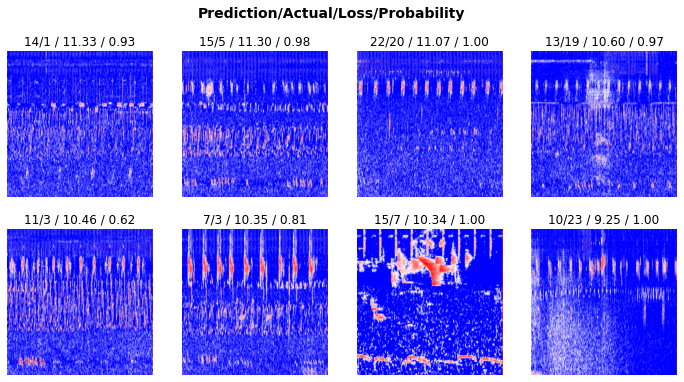

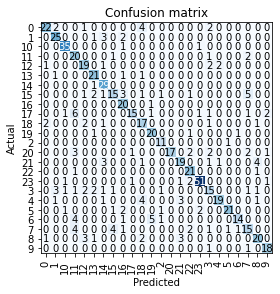

In [40]:
# 
interp = ClassificationInterpretation.from_learner(learn)
#interp.most_confused(min_val=6)
interp.plot_top_losses(8, nrows=2)
interp.plot_confusion_matrix()

In [10]:
# learn.export(fname='resnet34_15epoch_256_clips.pkl')
learn.export(fname='rn18_30ep_512_clip_full_aug1_medsub_112920_2.pkl') #30e = 0.717

In [29]:
path=TRAIN_AUDIO_ROOT.joinpath('tp_clips_and_full_med')
learn=load_learner(path.joinpath('rn18_30ep_512_clip_full_aug1_medsub_112920_2.pkl'))

True

In [41]:
#Score full spectrogram image using one model:
pngs=[png for png in TEST_AUDIO_ROOT.joinpath('full_med').glob('*.png')]
df_prob=pd.DataFrame(index=df_test['recording_id'],columns=['s%d' % i for i in range(0,24,1)])
prob_order= learn.dls.vocab
for png in pngs:
    fn=png.parts[-1]
    rec=fn.split('.')[0]
    _,_,probs=learn.predict(png)
#     print('Rec %s' % rec)
    for i,spec in enumerate(prob_order):
        df_prob['s%s' % spec][rec]=float(probs[i])
#         print('\ts%s - %f' %(spec,float(probs[i])))
df_prob.to_csv(DATA_ROOT.joinpath('rn34_30ep_512_clip_full_aug2_medsub_112920.csv'))
print('Finished')

Finished


In [36]:
df_prob

,s0,s1,s2,s3,s4,s5,s6,s7,s8,s9,...,s14,s15,s16,s17,s18,s19,s20,s21,s22,s23
recording_id,,,,,,,,,,,,,,,,,,,,,
000316da7,0.00729827,0.000577341,0.0402566,0.130807,9.61872e-05,0.00119428,0.00206835,9.06837e-05,0.00161502,0.000902254,...,0.000206506,0.000857741,0.000828037,0.000144241,8.74581e-05,0.00263745,4.9936e-05,3.52046e-05,0.000629195,1.77829e-05
003bc2cb2,2.49528e-07,1.4688e-06,9.6126e-07,0.00011497,1.30898e-06,8.6384e-06,2.50228e-05,4.26362e-05,3.38852e-07,1.05693e-05,...,8.94879e-05,1.34931e-07,0.999448,0.000207781,8.34973e-08,5.48604e-06,2.5787e-06,8.42607e-06,1.59002e-06,2.35543e-05
0061c037e,0.000482921,0.00503543,0.0638378,0.0518373,0.00113163,0.0157521,0.0115198,0.145357,0.00238344,0.00112694,...,0.018509,0.0290063,0.00278238,0.0435979,0.00168856,0.00607745,0.161121,0.00151364,0.0502725,0.304336
010eb14d3,0.0742567,0.370581,0.00879411,0.0136176,0.00139056,0.000869622,0.00117502,0.00275244,0.418832,0.00395856,...,0.00309728,0.0039568,0.000220827,0.000114781,0.0232334,5.60413e-05,0.00952553,0.0202961,0.00087399,0.000231986
011318064,0.00145595,0.00106744,0.00299032,0.00907271,0.000105213,0.000794457,0.00254,0.0189577,4.07521e-05,0.00140499,...,0.727844,0.217764,0.000148424,0.000306154,0.000160731,0.000524202,0.00156669,0.00411734,0.000620137,0.00103116
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ff68f3ac3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ff973e852,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ffa5cf6d6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [76]:
#Load in multiple .csv and take the mean:
fns=[DATA_ROOT.joinpath('resnet34_25epoch_512_clip_full_gen_aug2.csv'),
     DATA_ROOT.joinpath('resnet18_30epoch_512_clip_full_aug1.csv')]
df_load={}
for i,fn in enumerate(fns):
    df_load[i]= pd.read_csv(fn)
b=df_load[0]
for col in df_load[0].columns:
    if col != 'recording_id':
        b[col]=(0.25*df_load[0][col] + 0.75*df_load[1][col])
b.head()
b.to_csv(DATA_ROOT.joinpath('25-75_combo_test_resnet34_25_clip_full_gen_and_resnet18_clip_full_med.csv'),
        index=False)

In [72]:
col

'recording_id'

In [ ]:
#Score 10 spectrogram clips using one model:
pngs=[png for png in TEST_AUDIO_ROOT.glob('*.png')]
df_prob=pd.DataFrame(index=df_test['recording_id'],columns=['s%d' % i for i in range(0,24,1)])
prob_order= learn.dls.vocab
recs=next(os.walk(TEST_AUDIO_ROOT))[1]

for rec in recs:
    src=TEST_AUDIO_ROOT.joinpath(rec)
    pngs=[png for png in src.glob('*.png')]
    temp=np.zeros((10,len(prob_order)))
    for i,png in enumerate(pngs):
        fn=png.parts[-1]
        _,_,probs=learn.predict(png)
        temp[i,:]=probs
    mp=np.mean(temp,axis=0)
    for i,spec in enumerate(prob_order):
        df_prob['s%s' % spec][rec]=float(mp[i])
df_prob.to_csv(DATA_ROOT.joinpath('resnet18_clips_128squish_aug2_medsub_ontestclips.csv'))
print('Finished')

In [15]:
probs

TensorImage([1.4668e-04, 3.0317e-05, 2.0595e-04, 1.5770e-04, 9.3173e-03, 5.4053e-05,
        1.1377e-04, 3.6528e-05, 2.9794e-06, 9.3509e-06, 9.0793e-06, 1.4595e-05,
        9.8160e-01, 1.1926e-04, 6.9520e-05, 3.6074e-03, 1.9783e-03, 1.4915e-03,
        4.4915e-06, 6.8284e-05, 4.8242e-04, 1.1363e-04, 8.4104e-06, 3.6092e-04])

In [ ]:
##### 23 models: one model per TP species type:
path = TRAIN_AUDIO_ROOT.joinpath('clips') 
for spec in range(20,24,1): # np.unique(df_tp['species_id']): #   np.unique(df_tp['species_id'])
    def is_singer(x): return x.parts[-1].split('_')[1] == ('%d' % spec)
    #RandomSubsetSplitter(train_sz, valid_sz, seed=None) # batch_tfms=aug_transforms(mult=2)
    dls = ImageDataLoaders.from_path_func(
        path, get_image_files(path), valid=0.1, seed=42,
        label_func=is_singer, item_tfms=RandomResizedCrop(360, min_scale=0.3),num_workers=0,bs=6)

    learn = cnn_learner(dls, resnet34, metrics=error_rate)
    learn.fine_tune(3)
    
    mpath=Path('D:\\rfcx-species-audio-detection\\models').joinpath('res34_s%s' % spec)
    learn.save(mpath,with_opt=True,pickle_protocol=2)

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()
interp.plot_top_losses(4, nrows=1)

In [ ]:
#Score all photos using collection of expert models (this doesn't seem to work great but can get 0.338 in 1 v. all):
pngs=[png for png in TEST_AUDIO_ROOT.glob('*.png')]
#cols=['%d' % id for id in np.unique(df_tp['species_id'])]
df_prob=pd.DataFrame(index=df_test['recording_id'],columns=['s%d' % i for i in range(0,24,1)])
for spec in np.unique(df_tp['species_id']):
    mpath=Path('D:\\rfcx-species-audio-detection\\models').joinpath('res34_s%s' % spec)
    load_learn=learn.load(mpath,with_opt=True)
    print('Running model %d...' % spec)
    for png in pngs:
        fn=png.parts[-1]
        rec=fn.split('.')[0]
        is_singer,_,probs=load_learn.predict(png)
        df_prob['s%d' % spec][rec]=float(probs[1])
df_prob.to_csv(DATA_ROOT.joinpath('submission_1vall_360_RandResize_3epoch_clip.csv'))

# Notes
* Resnet 18 seems to do a bit better than 34 up to 20 epochs. 
* resnet18 512px squished 20 epochs data aug 2x with full TP and TP clips, clip median sub from each cip (old method) currently best performing (0.686 on competition).
* Resnet34 takes up less CUDA memory with larger image sizes -- > could try full 1080x1080 with additional info added to top pixels, if memory allows.
* Really need to implement the metric used by the competition! *from sklearn.metrics import label_ranking_average_precision_score* -- > where can I put this in fastai framework?
* Could create a new set of clips with:
1. Median as a seperate column at the end (or above as stated above)
2. Multi-true positive long clips with 1 TP removed (use even more of available data)
2. Take TP clips and concatenate random FP clips of different ID (i.e. train FP through ignoring)

In [ ]:
#Added to fastai/metrics.py: LRAP
import numpy as np
def LRAP(inp, targ, sigmoid=True):
    "Label ranking average precision -BI"
    if sigmoid: inp = inp.sigmoid()
    pred=inp.cpu().numpy()
    targ_v=targ.cpu().numpy()
    targ_array=np.zeros(pred.shape)
    for i,t in enumerate(targ_v):
        targ_array[i,t]=1
    return skm.label_ranking_average_precision_score(targ_array,pred)